# 1. Introduction - Aly Khater and Justin Sun

In this lab, you will learn how to do stock price prediction using LSTM (don't get too happy, because there is a random component to it you cannot predict which resembles more a random walk), perform movie classification, and generate random texts.

In [1]:
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import yfinance as yf
import random
import tensorflow as tf
from tensorflow import keras
%matplotlib inline

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Stock Price Classification

In this first part, you will try to predict stock prices of any company. Instead of doing a prediction, you will try to classify stocks as `strong_buy`, `buy`, `neutral`, `sell`, `strong_sell`, if the price in the next day closed $>5\%$, between $1\%$ and $5\%$, within $-1\%$ and $1\%$, between $-1\%$ and $-5\%$, and more than $-5\%$, respectively.

In [144]:
stock_ticket = 'ISRG'
stock = yf.download(stock_ticket, start='2021-01-01', end='2024-3-5', progress=False)
stock.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,275.279999,275.279999,262.959991,266.666656,266.666656,1781700
2021-01-05,264.630005,270.463318,263.130005,268.350006,268.350006,1363800
2021-01-06,265.093323,266.666656,262.286682,264.263336,264.263336,2071200
2021-01-07,266.290009,270.136658,263.333344,269.403320,269.403320,1285500
2021-01-08,268.073334,275.130005,268.019989,272.916656,272.916656,1428600


In [145]:
stock.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-02-27,386.459991,389.470001,385.279999,386.459991,386.459991,1042900
2024-02-28,384.600006,386.750000,383.559998,386.589996,386.589996,902800
2024-02-29,384.410004,389.260010,383.929993,385.600006,385.600006,2134800
2024-03-01,383.480011,399.670013,382.320007,397.899994,397.899994,2193900
2024-03-04,398.299988,403.000000,396.510010,400.589996,400.589996,1943700


Let's first only consider the closing values of the stock prices.

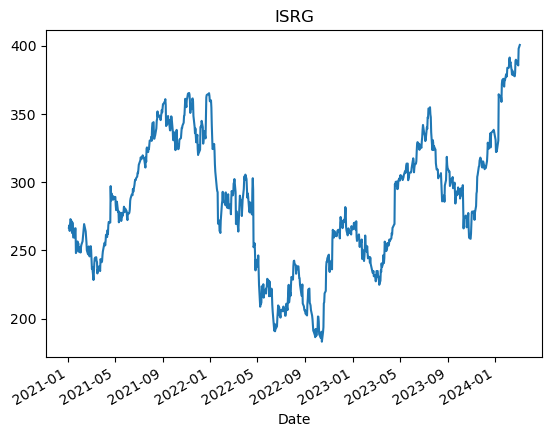

In [146]:
stock.Close.plot()
plt.title(stock_ticket)
plt.show()

In [147]:
stock_close = stock.Close

In [148]:
stock_close.head()

Date
2021-01-04    266.666656
2021-01-05    268.350006
2021-01-06    264.263336
2021-01-07    269.403320
2021-01-08    272.916656
Name: Close, dtype: float64

Now, let's consider the percent change of the next value with respect to the current value of the stock. Note that the last entry using `diff(-1)` will be `not a number`, because there is nothing to compare againt.

In [149]:
stock_next = -stock_close.diff(-1) / stock_close
stock_next.columns = ['Next']

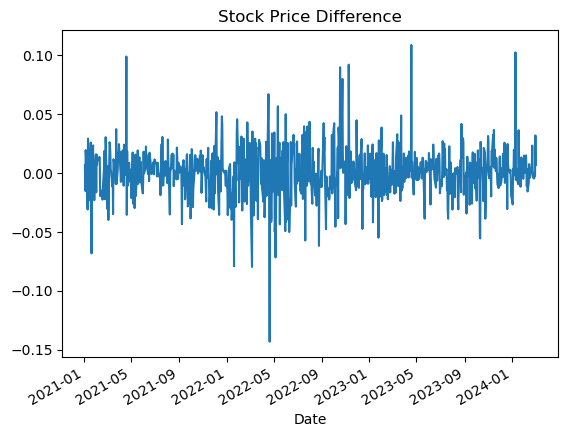

In [150]:
stock_next.plot()
plt.title('Stock Price Difference')
plt.show()

In [151]:
std = np.std(stock_next.values[:-1])
std

0.021479275113030976

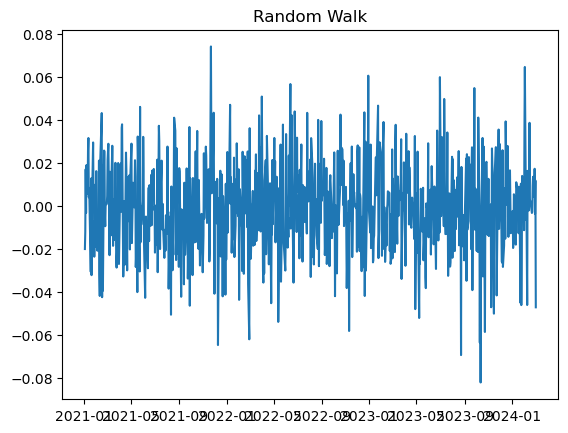

In [152]:
r = np.random.normal(0, std, size=len(stock_next[:-1]))
plt.plot(stock_next.index[:-1], r)
plt.title('Random Walk')
plt.show()

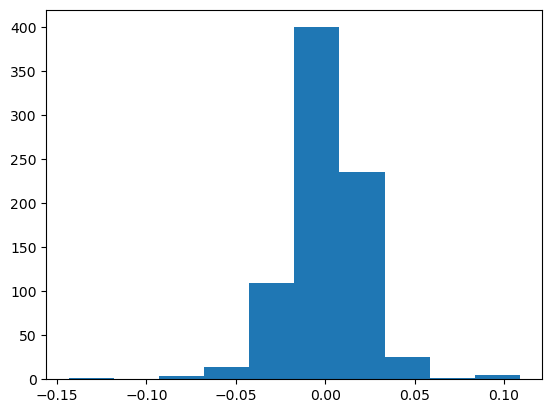

In [153]:
plt.hist(stock_next.values, bins=10)
plt.show()

In [154]:
stock_next.head()

Date
2021-01-04    0.006313
2021-01-05   -0.015229
2021-01-06    0.019450
2021-01-07    0.013041
2021-01-08   -0.006229
Name: Close, dtype: float64

In [155]:
stock_next.tail()

Date
2024-02-27    0.000336
2024-02-28   -0.002561
2024-02-29    0.031898
2024-03-01    0.006760
2024-03-04         NaN
Name: Close, dtype: float64

Because the last entry is `not-a-number`, let's remove the last entry and create the following class values:

- 0: sell
- 1: neutral
- 2: buy

In [156]:
last_date = stock_close.index[-1]
del stock_close[last_date]
del stock_next[last_date]
stock_next.tail()

Date
2024-02-26   -0.004662
2024-02-27    0.000336
2024-02-28   -0.002561
2024-02-29    0.031898
2024-03-01    0.006760
Name: Close, dtype: float64

In [157]:
values = stock_next.values
action = np.where(
    np.abs(values) > 0.02,
    np.sign(values) * 1,
    0
).astype(np.int32)

classes = len(np.unique(action))

classes, action

(3,
 array([ 0,  0,  0,  0,  0, -1,  1,  0, -1,  0,  1,  0, -1,  0,  1,  0,  0,
        -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,
         0, -1,  0,  1,  0, -1, -1,  0, -1,  1,  1,  0,  0,  0,  0,  0, -1,
         0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,
         0,  1,  0,  0,  0,  1, -1,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,
         0, -1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
         0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0, -1,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,
         0,  0, -1,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1, -1,  0,  0,
         0, -1,  1,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  1,  0,
        

(array([104., 584., 107.]),
 array([-1.        , -0.33333333,  0.33333333,  1.        ]),
 <BarContainer object of 3 artists>)

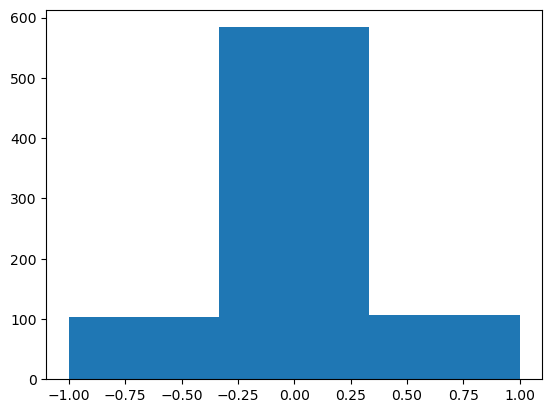

In [158]:
plt.hist(action, bins=3)

Note that `action` is still shifted by 2 from the values obtained before, so we can just add `2` to it.

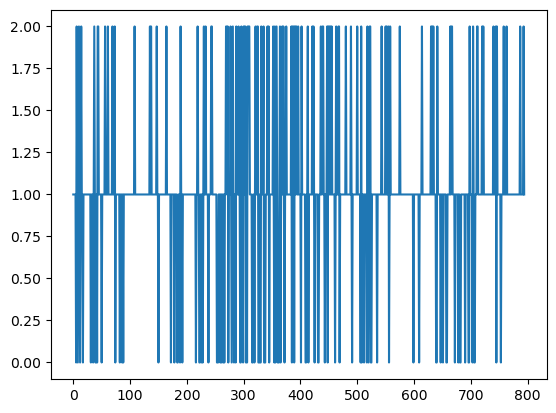

In [159]:
plt.plot(action + (classes - 2))

Let's create a training window where we can use LSTM to predict our classifier.

In [160]:
def split_data(data, action, window=1, validation_split=0.1):
    x = []
    y = []
    for i in range(window, len(data)):
        x.append(action[i-window:i])
        y.append(action[i])
        
    train_size = int((1 - validation_split) * len(x))
    
    x = np.array(x)
    y = np.array(y)
    
    return x[:train_size], y[:train_size], x[train_size:], y[train_size:]

In [161]:
data = values

data = stock_close.values
scaler = StandardScaler()
data = scaler.fit_transform(data.reshape(-1, 1)).flatten()

classes = len(np.unique(action))

x_train, y_train, x_test, y_test = split_data(
    data, action + (classes-2), window=20, validation_split=0.1)

print(classes, np.unique(y_train))

y_train = keras.utils.to_categorical(y_train, classes)
y_test = keras.utils.to_categorical(y_test, classes)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

3 [0 1 2]


((697, 20), (697, 3), (78, 20), (78, 3))

Now, you can create your network to try to predict wheather we should buy or sell stocks.

In [162]:
def CreateModel(i_shape, o_shape):
  x_i = keras.layers.Input(i_shape)
  x = keras.layers.Embedding(input_dim=3, output_dim=4)(x_i)
  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(128, activation='relu')(x)
  x = keras.layers.Dropout(0.5)(x)
  x = keras.layers.Dense(256, activation='relu')(x)
  x = keras.layers.Dropout(0.3)(x)
  x = keras.layers.Dense(1024, activation='relu')(x)
  x = keras.layers.Dense(o_shape[-1], activation='softmax')(x)
  
  return keras.models.Model(x_i, x)
  
optimizer = keras.optimizers.Adam(0.00001)
model = CreateModel(x_train.shape[1:], y_train.shape[1:])
model.compile(
    loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 20)]              0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 20, 4)             12        
_________________________________________________________________
flatten_9 (Flatten)          (None, 80)                0         
_________________________________________________________________
dense_48 (Dense)             (None, 128)               10368     
_________________________________________________________________
dropout_24 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_25 (Dropout)         (None, 256)               0  

In [163]:
history = model.fit(x_train, y_train, epochs=500, batch_size=64, 
          verbose=True, validation_data=(x_test, y_test))

Epoch 1/500
11/11 [==============================] - 0s 17ms/step - loss: 1.0939 - acc: 0.5753 - val_loss: 1.0931 - val_acc: 0.8462
Epoch 2/500
11/11 [==============================] - 0s 6ms/step - loss: 1.0898 - acc: 0.6786 - val_loss: 1.0892 - val_acc: 0.8590
Epoch 3/500
11/11 [==============================] - 0s 6ms/step - loss: 1.0866 - acc: 0.7202 - val_loss: 1.0851 - val_acc: 0.8590
Epoch 4/500
11/11 [==============================] - 0s 8ms/step - loss: 1.0832 - acc: 0.7231 - val_loss: 1.0810 - val_acc: 0.8590
Epoch 5/500
11/11 [==============================] - 0s 7ms/step - loss: 1.0791 - acc: 0.7231 - val_loss: 1.0768 - val_acc: 0.8590
Epoch 6/500
11/11 [==============================] - 0s 4ms/step - loss: 1.0757 - acc: 0.7231 - val_loss: 1.0724 - val_acc: 0.8590
Epoch 7/500
11/11 [==============================] - 0s 4ms/step - loss: 1.0721 - acc: 0.7231 - val_loss: 1.0679 - val_acc: 0.8590
Epoch 8/500
11/11 [==============================] - 0s 3ms/step - loss: 1.0675 - 

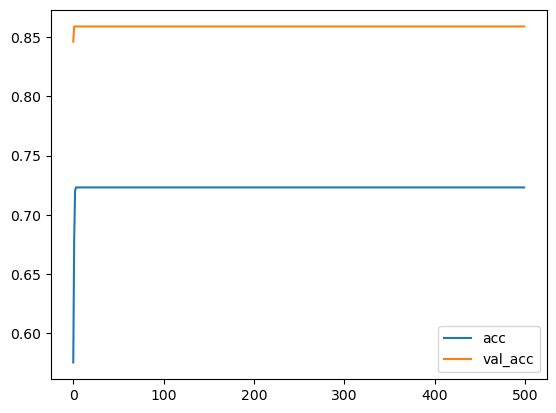

In [164]:
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [165]:
model.evaluate(x_train, y_train), model.evaluate(x_test, y_test)

3/3 [==============================] - 0s 2ms/step - loss: 0.5382 - acc: 0.8590


([0.7288063764572144, 0.7230989933013916],
 [0.5382176637649536, 0.8589743375778198])

In [166]:
p_test = model.predict(x_test)
p_train = model.predict(x_train)
print('distribution of classes:', np.sum(y_train, axis=0))
print('acc of model:', np.mean(np.argmax(y_test, axis=1) == np.argmax(p_test, axis=1), axis=0))
y_v = np.argmax(y_train, axis=1)
p_v = np.argmax(p_train, axis=1)

# we will check if at least we got the signs correctly

def get_misses_per_class(y, p):
    y_v = np.argmax(y, axis=1)
    p_v = np.argmax(p, axis=1)

    y_s = y_v - (classes - 2)
    p_s = p_v - (classes - 2)

    misses = {c - (classes-2) : 0 for c in range(classes) }
    total = {c - (classes-2): 0 for c in range(classes) }

    for i in range(len(y_s)):
        misses[y_s[i]] += (y_s[i] == p_s[i])
        total[y_s[i]] += 1

    for k in total:
        print(k, misses[k], total[k], misses[k]/total[k])


print('train')
get_misses_per_class(y_train, p_train)
print('test')
get_misses_per_class(y_test, p_test)
print(list(zip(np.argmax(y_test, axis=-1), np.argmax(p_test, axis=-1))))


distribution of classes: [ 98. 504.  95.]
acc of model: 0.8589743589743589
train
-1 0 98 0.0
0 504 504 1.0
1 0 95 0.0
test
-1 0 2 0.0
0 67 67 1.0
1 0 9 0.0
[(1, 1), (1, 1), (1, 1), (2, 1), (1, 1), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (2, 1), (1, 1), (1, 1), (1, 1), (2, 1), (0, 1), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (0, 1), (1, 1), (1, 1), (1, 1), (1, 1), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (2, 1), (1, 1)]


Not very impressive, as the majority of the time we are just predicting do not do anything. Also, our prediction for upward movements almost never got it right.

Now, it is your turn to try to improve our stock prediction using LSTM's or GRUs. 

Another good datapoint is the following. In most of the cases, a good classifier needs to beat the previous day prediction as well.

In [167]:
acc_previous_day = 0
movement_right = 0

p_train[1:] = y_train[0:-1]
p_test[0] = y_train[-1]
p_test[1:] = y_test[0:-1]

print('accuracy of training set:', np.mean(np.argmax(y_train, axis=-1) == np.argmax(p_train, axis=-1), axis=0))
print('accuracy of test set:', np.mean(np.argmax(y_test, axis=-1) == np.argmax(p_test, axis=-1), axis=0))
print('train')
get_misses_per_class(y_train, p_train)
print('test')
get_misses_per_class(y_test, p_test)

accuracy of training set: 0.599713055954089
accuracy of test set: 0.7435897435897436
train
-1 21 98 0.21428571428571427
0 381 504 0.7559523809523809
1 16 95 0.16842105263157894
test
-1 0 2 0.0
0 58 67 0.8656716417910447
1 0 9 0.0


In [168]:
print(np.argmax(y_train[:20], axis=-1))
print(np.argmax(p_train[:20], axis=-1))

[1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 2 1 0]
[1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 2 1]


# 3. IMDB Text Classification

In this next lab, you will create a text classification using LSTMs.

In [34]:
from keras import preprocessing
from keras.datasets import imdb

In [35]:
# Load imdb dataset and print a few samples to check.
#
# IMDB: sentence (x) -> positive/negative (y)
#
# “The food was really good”                             -> pos
# “The chicken crossed the road because it was uncooked” -> neg

num_words = 10000
maxlen = 100
embedded_size = 16

In [36]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)

17473536/17464789 [==============================] - 4s 0us/step


In [37]:
d = imdb.get_word_index()
for w in d:
    if d[w] == 22:
        print(w)
        break

1654784/1641221 [==============================] - 1s 0us/step
you


In [38]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((25000,), (25000,), (25000,), (25000,))

In [39]:
x_train[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

x_train has a size (training_size, ). Because the sentences have variable size, we cannot represent this in matrix format.

The first step is to make the column size constant. We do that by "padding" the sentences. If the sentences are bigger, we clip them. If they are smaller, we insert a "NO_WORD" token to the sentence.

In [42]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)
x_train.shape, x_test.shape

((25000, 100), (25000, 100))

In [43]:
x_train[0]

array([1415,   33,    6,   22,   12,  215,   28,   77,   52,    5,   14,
        407,   16,   82,    2,    8,    4,  107,  117, 5952,   15,  256,
          4,    2,    7, 3766,    5,  723,   36,   71,   43,  530,  476,
         26,  400,  317,   46,    7,    4,    2, 1029,   13,  104,   88,
          4,  381,   15,  297,   98,   32, 2071,   56,   26,  141,    6,
        194, 7486,   18,    4,  226,   22,   21,  134,  476,   26,  480,
          5,  144,   30, 5535,   18,   51,   36,   28,  224,   92,   25,
        104,    4,  226,   65,   16,   38, 1334,   88,   12,   16,  283,
          5,   16, 4472,  113,  103,   32,   15,   16, 5345,   19,  178,
         32])

In [44]:
def CreateModel(i_shape):
    x_i = keras.layers.Input(i_shape)
    x = keras.layers.Embedding(num_words, embedded_size,
                               input_length=maxlen)(x_i)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(1, activation="sigmoid")(x)

    return keras.models.Model(x_i, x)

model = CreateModel(x_train.shape[1:])
model.summary()

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 16)           160000    
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1601      
Total params: 161,601
Trainable params: 161,601
Non-trainable params: 0
_________________________________________________________________


In [45]:
model.fit(
    x_train, y_train, epochs=20, batch_size=64,
    validation_split=0.2)

Epoch 1/20
313/313 [==============================] - 1s 3ms/step - loss: 0.6181 - acc: 0.6776 - val_loss: 0.4476 - val_acc: 0.8144
Epoch 2/20
313/313 [==============================] - 1s 2ms/step - loss: 0.3381 - acc: 0.8672 - val_loss: 0.3400 - val_acc: 0.8506
Epoch 3/20
313/313 [==============================] - 1s 2ms/step - loss: 0.2376 - acc: 0.9131 - val_loss: 0.3273 - val_acc: 0.8514
Epoch 4/20
313/313 [==============================] - 1s 2ms/step - loss: 0.1767 - acc: 0.9432 - val_loss: 0.3346 - val_acc: 0.8514
Epoch 5/20
313/313 [==============================] - 1s 2ms/step - loss: 0.1273 - acc: 0.9675 - val_loss: 0.3498 - val_acc: 0.8498
Epoch 6/20
313/313 [==============================] - 1s 2ms/step - loss: 0.0883 - acc: 0.9833 - val_loss: 0.3648 - val_acc: 0.8464
Epoch 7/20
313/313 [==============================] - 1s 2ms/step - loss: 0.0595 - acc: 0.9925 - val_loss: 0.3856 - val_acc: 0.8436
Epoch 8/20
313/313 [==============================] - 1s 2ms/step - loss: 0.

In [46]:
eval_result = model.evaluate(x_test, y_test)
eval_result[1]

782/782 [==============================] - 1s 823us/step - loss: 0.6015 - acc: 0.8365


0.8365200161933899

- What's the current accuracy for this model? **0.8365200161933899**
- Try to add a preloaded embedded from Glove from this model, see the
suggestion in https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
- Question: why does this model may help you get better accuracy?
- **Answer: using pre-trained embeddings is relevant for natural processing tasks were little training data is available (functionally the embeddings act as an injection of outside information which might prove useful for your model).**
- Try using an LSTM instead of the models above.

### Glove pre-trained word embeddings

In [181]:
import os

# Only the TensorFlow backend supports string inputs.
os.environ["KERAS_BACKEND"] = "tensorflow"

import pathlib
import numpy as np
import tensorflow.data as tf_data
import keras
from keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [184]:
from tensorflow.keras.utils import get_file

data_path = get_file(
    "news20.tar.gz",
    "http://www.cs.cmu.edu/afs/cs.cmu.edu/project/theo-20/www/data/news20.tar.gz",
    untar=True,
)

17342464/17329808 [==============================] - 31s 2us/step


In [185]:
data_dir = pathlib.Path(data_path).parent / "20_newsgroup"
dirnames = os.listdir(data_dir)
print("Number of directories:", len(dirnames))
print("Directory names:", dirnames)

fnames = os.listdir(data_dir / "comp.graphics")
print("Number of files in comp.graphics:", len(fnames))
print("Some example filenames:", fnames[:5])

Number of directories: 20
Directory names: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
Number of files in comp.graphics: 1000
Some example filenames: ['37261', '37913', '37914', '37915', '37916']


In [186]:
print(open(data_dir / "comp.graphics" / "38987").read())

Newsgroups: comp.graphics
Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!howland.reston.ans.net!agate!dog.ee.lbl.gov!network.ucsd.edu!usc!rpi!nason110.its.rpi.edu!mabusj
From: mabusj@nason110.its.rpi.edu (Jasen M. Mabus)
Subject: Looking for Brain in CAD
Message-ID: <c285m+p@rpi.edu>
Nntp-Posting-Host: nason110.its.rpi.edu
Reply-To: mabusj@rpi.edu
Organization: Rensselaer Polytechnic Institute, Troy, NY.
Date: Thu, 29 Apr 1993 23:27:20 GMT
Lines: 7

Jasen Mabus
RPI student

	I am looking for a hman brain in any CAD (.dxf,.cad,.iges,.cgm,etc.) or picture (.gif,.jpg,.ras,etc.) format for an animation demonstration. If any has or knows of a location please reply by e-mail to mabusj@rpi.edu.

Thank you in advance,
Jasen Mabus  



In [187]:
samples = []
labels = []
class_names = []
class_index = 0
for dirname in sorted(os.listdir(data_dir)):
    class_names.append(dirname)
    dirpath = data_dir / dirname
    fnames = os.listdir(dirpath)
    print("Processing %s, %d files found" % (dirname, len(fnames)))
    for fname in fnames:
        fpath = dirpath / fname
        f = open(fpath, encoding="latin-1")
        content = f.read()
        lines = content.split("\n")
        lines = lines[10:]
        content = "\n".join(lines)
        samples.append(content)
        labels.append(class_index)
    class_index += 1

print("Classes:", class_names)
print("Number of samples:", len(samples))

Processing alt.atheism, 1000 files found
Processing comp.graphics, 1000 files found
Processing comp.os.ms-windows.misc, 1000 files found
Processing comp.sys.ibm.pc.hardware, 1000 files found
Processing comp.sys.mac.hardware, 1000 files found
Processing comp.windows.x, 1000 files found
Processing misc.forsale, 1000 files found
Processing rec.autos, 1000 files found
Processing rec.motorcycles, 1000 files found
Processing rec.sport.baseball, 1000 files found
Processing rec.sport.hockey, 1000 files found
Processing sci.crypt, 1000 files found
Processing sci.electronics, 1000 files found
Processing sci.med, 1000 files found
Processing sci.space, 1000 files found
Processing soc.religion.christian, 997 files found
Processing talk.politics.guns, 1000 files found
Processing talk.politics.mideast, 1000 files found
Processing talk.politics.misc, 1000 files found
Processing talk.religion.misc, 1000 files found
Classes: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.ha

In [188]:
# Shuffle the data
seed = 1337
rng = np.random.RandomState(seed)
rng.shuffle(samples)
rng = np.random.RandomState(seed)
rng.shuffle(labels)

# Extract a training & validation split
validation_split = 0.2
num_validation_samples = int(validation_split * len(samples))
train_samples = samples[:-num_validation_samples]
val_samples = samples[-num_validation_samples:]
train_labels = labels[:-num_validation_samples]
val_labels = labels[-num_validation_samples:]

In [189]:
from tensorflow.keras import layers
# from tensorflow import tf_data

vectorizer = layers.TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tf_data.Dataset.from_tensor_slices(train_samples).batch(128)
vectorizer.adapt(text_ds)

vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'the', 'to', 'of']

In [190]:
output = vectorizer([["the cat sat on the mat"]])
output.numpy()[0, :6]

array([   2, 3456, 1682,   15,    2, 5776], dtype=int64)

In [191]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [192]:
test = ["the", "cat", "sat", "on", "the", "mat"]
[word_index[w] for w in test]

[2, 3456, 1682, 15, 2, 5776]

In [193]:
path_to_glove_file = "glove.6B/glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file, encoding='utf-8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [194]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 18019 words (1981 misses)


In [195]:
from keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    trainable=False,
)
embedding_layer.build((1,))
embedding_layer.set_weights([embedding_matrix])

In [196]:
int_sequences_input = keras.Input(shape=(None,), dtype="int32")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(128, 5, activation="relu")(embedded_sequences)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(len(class_names), activation="softmax")(x)
model = keras.Model(int_sequences_input, preds)
model.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding_10 (Embedding)     (None, None, 100)         2000200   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 128)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 128)         82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 128)         820

In [197]:
x_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
x_val = vectorizer(np.array([[s] for s in val_samples])).numpy()

y_train = np.array(train_labels)
y_val = np.array(val_labels)

In [198]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["acc"]
)

early_stopping = EarlyStopping(monitor='val_acc', patience=10, min_delta=0.001, mode='max', verbose=1)
history = model.fit(x_train, y_train,
                    epochs=100, 
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping])  

Epoch 1/100
125/125 [==============================] - 6s 8ms/step - loss: 2.6559 - acc: 0.1373 - val_loss: 2.1287 - val_acc: 0.2711
Epoch 2/100
125/125 [==============================] - 1s 6ms/step - loss: 1.9604 - acc: 0.3200 - val_loss: 1.8584 - val_acc: 0.3351
Epoch 3/100
125/125 [==============================] - 1s 6ms/step - loss: 1.5588 - acc: 0.4667 - val_loss: 1.3470 - val_acc: 0.5284
Epoch 4/100
125/125 [==============================] - 1s 6ms/step - loss: 1.2975 - acc: 0.5522 - val_loss: 1.1317 - val_acc: 0.6157
Epoch 5/100
125/125 [==============================] - 1s 6ms/step - loss: 1.1258 - acc: 0.6138 - val_loss: 1.0829 - val_acc: 0.6272
Epoch 6/100
125/125 [==============================] - 1s 6ms/step - loss: 0.9902 - acc: 0.6589 - val_loss: 1.0061 - val_acc: 0.6552
Epoch 7/100
125/125 [==============================] - 1s 6ms/step - loss: 0.8657 - acc: 0.7015 - val_loss: 1.0007 - val_acc: 0.6752
Epoch 8/100
125/125 [==============================] - 1s 6ms/step - 

### Now Use LSTM

In [170]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Assuming you have the maximum sequence length after vectorization
max_features = 20000  # This is the size of the vocabulary in the vectorizer
max_len = x_train.shape[1]  # The length of sequences processed after vectorization

model = models.Sequential()
model.add(layers.Embedding(input_dim=max_features, output_dim=128, input_length=max_len))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.LSTM(64))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(np.unique(y_train)), activation='softmax'))  # Assuming classification task

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 200, 128)          2560000   
                                                                 
 lstm_7 (LSTM)               (None, 200, 64)           49408     
                                                                 
 lstm_8 (LSTM)               (None, 64)                33024     
                                                                 
 dense_25 (Dense)            (None, 64)                4160      
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_26 (Dense)            (None, 20)                1300      
                                                                 
Total params: 2,647,892
Trainable params: 2,647,892
No

In [172]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, min_delta=0.001, mode='max', verbose=1)
history = model.fit(x_train, y_train,
                    epochs=100, 
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping])

Epoch 1/100
125/125 [==============================] - 5s 41ms/step - loss: 2.6923 - accuracy: 0.0974 - val_loss: 2.6045 - val_accuracy: 0.0970
Epoch 2/100
125/125 [==============================] - 5s 41ms/step - loss: 2.6576 - accuracy: 0.0998 - val_loss: 2.6008 - val_accuracy: 0.1008
Epoch 3/100
125/125 [==============================] - 5s 43ms/step - loss: 2.5756 - accuracy: 0.1080 - val_loss: 2.5115 - val_accuracy: 0.1273
Epoch 4/100
125/125 [==============================] - 5s 43ms/step - loss: 2.6925 - accuracy: 0.0979 - val_loss: 2.8452 - val_accuracy: 0.0738
Epoch 5/100
125/125 [==============================] - 6s 45ms/step - loss: 2.7972 - accuracy: 0.0843 - val_loss: 2.6458 - val_accuracy: 0.1053
Epoch 6/100
125/125 [==============================] - 6s 49ms/step - loss: 2.6252 - accuracy: 0.1028 - val_loss: 2.6226 - val_accuracy: 0.1043
Epoch 7/100
125/125 [==============================] - 6s 50ms/step - loss: 2.9550 - accuracy: 0.0643 - val_loss: 2.9963 - val_accuracy:

# 4. Generate Text from Nietzsche's Writings

In this example, you will generate text from Nietzsche's writings.

At least 20 epochs are required before the generated text
starts sounding coherent.

It is recommended to run this script on GPU, as recurrent
networks are quite computationally intensive.

If you try this script on new data, make sure your corpus
has at least ~100k characters. ~1M is better.

In [47]:
path = keras.utils.get_file("nietzsche.txt",
        origin="https://s3.amazonaws.com/text-datasets/nietzsche.txt")

text = open(path).read().lower()
print("corpus length:", len(text))

614400/600901 [==============================] - 1s 1us/step
corpus length: 600901


In [48]:
chars = set(text)
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

total chars: 59


In [49]:
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 100
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print("nb sequences:", len(sentences))

nb sequences: 200267


In [50]:
print("Vectorization...")
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.int8)
y = np.zeros((len(sentences), len(chars)), dtype=np.int8)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Vectorization...


In [51]:
# build the model: 2 stacked LSTM
print("Build model...")
xi = keras.layers.Input((maxlen, len(chars)))
x = keras.layers.GRU(256, return_sequences=True)(xi)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.GRU(256, return_sequences=False)(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(len(chars))(x)
x = keras.layers.Activation("softmax")(x)

model = keras.models.Model(inputs=xi, outputs=x)
model.summary()

Build model...
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100, 59)]         0         
_________________________________________________________________
gru (GRU)                    (None, 100, 256)          243456    
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 256)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 256)               394752    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 59)                15163     
_________________________________________________________________
activation (Activation)      (None, 59)     

In [52]:
adam = keras.optimizers.Adam(0.003)

model.compile(loss="categorical_crossentropy", optimizer=adam)

In [53]:
def sample(a, temperature=1.0):
    # helper function to sample an index from a probability array
    a = (np.log(a + 1e-8) / temperature).astype(np.float64)
    a = np.exp(a) / np.sum(np.exp(a))
    try:
      sample_result = np.argmax(np.random.multinomial(1, a, 1))
    except ValueError:
      error = 1.0 - np.sum(a)
      a[0] += error
      sample_result = np.argmax(np.random.multinomial(1, a, 1))
    return sample_result

In [ ]:
import sys

# train the model, output generated text after each iteration
for iteration in range(1, 60):
    print()
    print("-" * 50)
    print("Iteration", iteration)

    model.fit(X, y, batch_size=1024, epochs=4)
    model.save_weights("weights.hdf5")

    start_index = random.randint(0, len(text) - maxlen - 1)

    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print()
        print("----- diversity:", diversity)

        generated = ""
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print("----- Generating with seed: '" + sentence + "'")
        sys.stdout.write(generated)

        for i in range(200):
            x = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x[0, t, char_indices[char]] = 1.

            # predict next char
            preds = model.predict(x, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            # full sentence being generated
            generated += next_char

            # shift sentence
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
            
            # let's consider only one sentence
            if next_char == ".":
              break
        print()


--------------------------------------------------
Iteration 1
Epoch 1/4
196/196 [==============================] - 15s 73ms/step - loss: 2.3580
Epoch 2/4
196/196 [==============================] - 14s 74ms/step - loss: 1.8701
Epoch 3/4
196/196 [==============================] - 15s 74ms/step - loss: 1.6946
Epoch 4/4
196/196 [==============================] - 15s 75ms/step - loss: 1.5920

----- diversity: 0.2
----- Generating with seed: 'wish to give them pleasure (children
their parents, pupils their teacher, and well disposed persons '
wish to give them pleasure (children
their parents, pupils their teacher, and well disposed persons and the subjection of the superficial that the superion of the superiors of the superficial in the supersing the consequences the subjection of the sense is the superficial the supers of the superfici

----- diversity: 0.5
----- Generating with seed: 'wish to give them pleasure (children
their parents, pupils their teacher, and well disposed persons '
w

- Pick up one set of data samples from linux kernel source code (https://github.com/torvalds/linux)
- Modify the model to be trained in the corpus
- Present the results

In [173]:
file_path = "signal.c"

with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read().lower()
    
print("corpus length:", len(text))

corpus length: 128746


In [174]:
chars = set(text)
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

total chars: 70


In [175]:
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 100
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print("nb sequences:", len(sentences))

nb sequences: 42882


In [176]:
print("Vectorization...")
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.int8)
y = np.zeros((len(sentences), len(chars)), dtype=np.int8)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Vectorization...


In [177]:
# build the model: 2 stacked LSTM
print("Build model...")
xi = keras.layers.Input((maxlen, len(chars)))
x = keras.layers.GRU(256, return_sequences=True)(xi)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.GRU(256, return_sequences=False)(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(len(chars))(x)
x = keras.layers.Activation("softmax")(x)

model = keras.models.Model(inputs=xi, outputs=x)
model.summary()

Build model...
Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 100, 70)]         0         
_________________________________________________________________
gru (GRU)                    (None, 100, 256)          251904    
_________________________________________________________________
dropout_26 (Dropout)         (None, 100, 256)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 256)               394752    
_________________________________________________________________
dropout_27 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 70)                17990     
_________________________________________________________________
activation (Activation)      (None, 70)    

In [178]:
adam = keras.optimizers.Adam(0.003)

model.compile(loss="categorical_crossentropy", optimizer=adam)

In [179]:
def sample(a, temperature=1.0):
    # helper function to sample an index from a probability array
    a = (np.log(a + 1e-8) / temperature).astype(np.float64)
    a = np.exp(a) / np.sum(np.exp(a))
    try:
      sample_result = np.argmax(np.random.multinomial(1, a, 1))
    except ValueError:
      error = 1.0 - np.sum(a)
      a[0] += error
      sample_result = np.argmax(np.random.multinomial(1, a, 1))
    return sample_result

In [180]:
import sys

# train the model, output generated text after each iteration
for iteration in range(1, 60):
    print()
    print("-" * 50)
    print("Iteration", iteration)

    model.fit(X, y, batch_size=1024, epochs=4)
    model.save_weights("weights.hdf5")

    start_index = random.randint(0, len(text) - maxlen - 1)

    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print()
        print("----- diversity:", diversity)

        generated = ""
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print("----- Generating with seed: '" + sentence + "'")
        sys.stdout.write(generated)

        for i in range(200):
            x = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x[0, t, char_indices[char]] = 1.

            # predict next char
            preds = model.predict(x, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            # full sentence being generated
            generated += next_char

            # shift sentence
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
            
            # let's consider only one sentence
            if next_char == ".":
              break
        print()


--------------------------------------------------
Iteration 1
Epoch 1/4
42/42 [==============================] - 7s 76ms/step - loss: 3.3370
Epoch 2/4
42/42 [==============================] - 3s 76ms/step - loss: 2.4660
Epoch 3/4
42/42 [==============================] - 3s 75ms/step - loss: 2.1176
Epoch 4/4
42/42 [==============================] - 3s 76ms/step - loss: 1.8395

----- diversity: 0.2
----- Generating with seed: 'set(si_pid);
	check_offset(si_uid);
	check_offset(si_value);

	/* sigchld */
	check_offset(si_pid);
'
set(si_pid);
	check_offset(si_uid);
	check_offset(si_value);

	/* sigchld */
	check_offset(si_pid);
		if (!signal_sig_info(sig, &sig, &new, &uss);
		if (!signal();
		if (!info->si_signal();
		if (!signal_signal();
		if (!sig);
		if (!signal->signal->signal->signal->siglock);
				if (!signal_siginfo(

----- diversity: 0.5
----- Generating with seed: 'set(si_pid);
	check_offset(si_uid);
	check_offset(si_value);

	/* sigchld */
	check_offset(si_pid);
'
set(si_pid);
